In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import pickle

In [3]:
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
Y_train = np.load("Y_train.npy")
Y_val = np.load("Y_val.npy")

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(100, 100, 3))

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [6]:
# Defining the dense layer
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Dropout(rate=0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(Y_train.shape[1], activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                294976    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 15,010,054
Trainable params: 15,010,054
Non-trainable params: 0
_________________________________________________________________


In [8]:
# freeezing
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'categorical_accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                294976    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 15,010,054
Trainable params: 13,274,566
Non-trainable params: 1,735,488
_________________________________________________________________


In [11]:
history = model.fit(X_train,
                    Y_train,
                    batch_size=100,
                    epochs= 20,
                    steps_per_epoch=X_train.shape[0]//100,
                    validation_data=(X_val, Y_val))

Epoch 1/20
130/130 [==============================] - 22s 170ms/step - loss: 11.8448 - accuracy: 0.3339 - categorical_accuracy: 0.3339 - val_loss: 1.5964 - val_accuracy: 0.3173 - val_categorical_accuracy: 0.3173
Epoch 2/20
130/130 [==============================] - 21s 158ms/step - loss: 1.3062 - accuracy: 0.5069 - categorical_accuracy: 0.5069 - val_loss: 1.3722 - val_accuracy: 0.5559 - val_categorical_accuracy: 0.5559
Epoch 3/20
130/130 [==============================] - 21s 160ms/step - loss: 0.8565 - accuracy: 0.6917 - categorical_accuracy: 0.6917 - val_loss: 0.7129 - val_accuracy: 0.7192 - val_categorical_accuracy: 0.7192
Epoch 4/20
130/130 [==============================] - 21s 162ms/step - loss: 0.6749 - accuracy: 0.7720 - categorical_accuracy: 0.7720 - val_loss: 0.4950 - val_accuracy: 0.8270 - val_categorical_accuracy: 0.8270
Epoch 5/20
130/130 [==============================] - 21s 163ms/step - loss: 0.5987 - accuracy: 0.8111 - categorical_accuracy: 0.8111 - val_loss: 0.7242 - 

In [12]:
model.save("scene_classification_transfer_learning_1.h5")

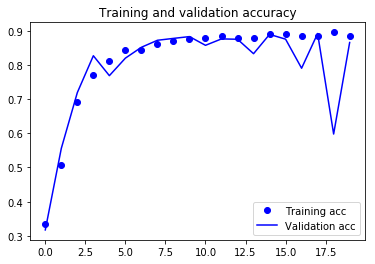

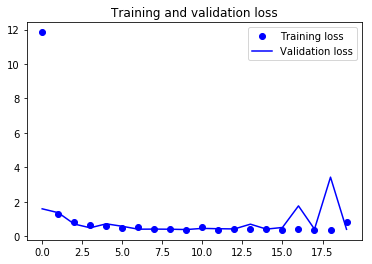

In [17]:
np.save("transfer_learning_history.npy", history.history,allow_pickle=True)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

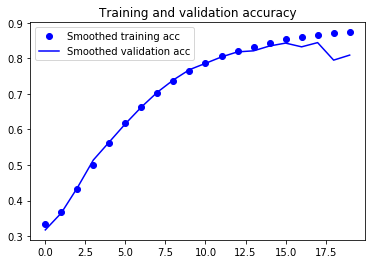

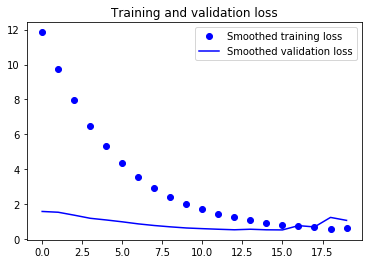

In [18]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Note that the loss curve does not show any real improvement. You may wonder, how could accuracy improve if the 
loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy 
is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability 
predicted by the model. The model may still be improving even if this isn't reflected in the average loss. (Source: notebook 5.3 given by Prof Pauca)

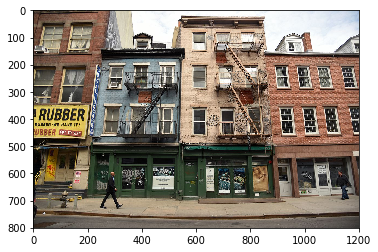

In [43]:
import requests
from PIL import Image
from io import BytesIO

url = "https://cdn.vox-cdn.com/thumbor/Mt2SHO8KepxiyP-dIB4qruN_dNE=/0x0:1500x1001/1200x0/filters:focal(0x0:1500x1001):no_upscale()/cdn.vox-cdn.com/uploads/chorus_asset/file/10177719/20_Kensinger_325_327_Canal_Street_DSC_7353.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
_img = np.array(img.convert("L"))
_img = _img / 255.
_img = np.resize(_img, (100, 100, 3))
_img = _img.reshape((1,) + _img.shape)
plt.imshow(img)
plt.show()

In [44]:
prediction = model.predict(_img)
print ("Prediction", np.argmax(prediction, axis=1))

Prediction [0]


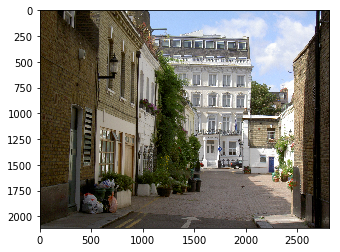

Prediction [4]


In [45]:
url = "https://upload.wikimedia.org/wikipedia/commons/3/39/Typical_Street_In_The_Royal_Borough_Of_Kensington_And_Chelsea_In_London.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
_img = np.array(img.convert("L"))
_img = _img / 255.
_img = np.resize(_img, (100, 100, 3))
_img = _img.reshape((1,) + _img.shape)
prediction = model.predict(_img)
plt.imshow(img)
plt.show()
print ("Prediction" , np.argmax(prediction, axis=1))